## Model Training

In [1]:
import utils as utils
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## importing models
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier, EnsembleVoteClassifier

In [3]:
from sklearn.metrics import accuracy_score, make_scorer, f1_score, classification_report, plot_confusion_matrix

# preprocessing
from category_encoders import OrdinalEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.model_selection import ParameterGrid

from sklearn.preprocessing import LabelEncoder, FunctionTransformer
    
from sklearn.impute import SimpleImputer

# other libs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from datetime import datetime

pd.options.display.max_columns = None
warnings.simplefilter("ignore")

## Data Preparation & Selection

In [4]:
# import all data
data = pd.read_csv(
    '../data/processed/train.csv', 
    index_col='id', 
    parse_dates=['date_recorded'], 
    infer_datetime_format=True
)

In [5]:
# import holdout data
datatest = pd.read_csv(
    '../data/processed/test.csv', 
   index_col='id', 
   parse_dates=['date_recorded'], 
   infer_datetime_format=True
)

In [6]:
# predict label
y = data.status_group

# all features
X = data.drop('status_group', axis=1)

In [7]:
# encode target as int's
y_transformer = LabelEncoder()
y = y_transformer.fit_transform(y)

In [151]:
y_transformer.inverse_transform(np.array([0,1,2]).reshape(-1,1))

array(['functional', 'functional needs repair', 'non functional'],
      dtype=object)

In [8]:
# select numeric columns,
# TODO: Normalize or Scale (geoposition data? (lat, long))
NUMERIC_COLUMNS = X.select_dtypes(include=['number']).columns
NUMERIC_COLUMNS

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'region_code', 'district_code', 'population', 'construction_year'],
      dtype='object')

In [9]:
# select categorical columns
TEXT_COLUMNS = X.select_dtypes(include=['object']).columns
X[TEXT_COLUMNS] = X[TEXT_COLUMNS].astype(str)
TEXT_COLUMNS

Index(['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
       'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'extraction_type', 'extraction_type_class',
       'management', 'payment', 'water_quality', 'quality_group', 'quantity',
       'source', 'source_class', 'waterpoint_type'],
      dtype='object')

In [10]:
DATE_COLUMNS=['date_recorded_day', 'date_recorded_month', 'date_recorded_year']

In [11]:
FINAL_COLUMNS = list(DATE_COLUMNS) + list(NUMERIC_COLUMNS) + list(TEXT_COLUMNS)

In [14]:
# TODO: stratified by categorical features
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.33, 
    stratify=y
)

### Preprocessing with Pipelines!

In [17]:
# define transformers for develop a sklearn-pipeline
get_numeric_data = FunctionTransformer(lambda df: df[NUMERIC_COLUMNS])
get_text_data = FunctionTransformer(lambda df: df[TEXT_COLUMNS])
get_date_data = FunctionTransformer(lambda df: df[['date_recorded']])

transform_date_data = FunctionTransformer(lambda df: df.assign(
    date_recorded_day=df.date_recorded.dt.day,
    date_recorded_month=df.date_recorded.dt.month,
    date_recorded_year=df.date_recorded.dt.year
).drop('date_recorded', axis=1))

fill_empty_data = FunctionTransformer(lambda df: df.fillna('mean', axis=1)) # may be a SimpleImputer

In [18]:
def preprocess_pipeline():
    return FeatureUnion(
                transformer_list = [
                    ('date_features', Pipeline([
                        ('selector', get_date_data),
                        ('transform', transform_date_data)
                    ])),
                    ('numeric_features', Pipeline([
                        ('selector', get_numeric_data),
                        ('imputer', SimpleImputer()),
                    ])),
                    ('text_features', Pipeline([
                        ('selector', get_text_data),
                        #('imputer', fill_empty_data),
                        ('vectorizer', OrdinalEncoder())
                        #('decomposition', TruncatedSVD(n_components=50))
                    ]))
                 ]
            )

In [19]:
def get_pipeline_model(clf):
    return Pipeline([
        ('preprocess', preprocess_pipeline()),
        ('clf', clf)
    ])

In [20]:
feature_pipeline = preprocess_pipeline()

In [21]:
# preprocess X_train and X_test separately, avoiding data-leakage
fp = feature_pipeline.fit(X_train, y_train)

In [22]:
X_train_preprocess = pd.DataFrame(
    fp.transform(X_train), 
    columns=FINAL_COLUMNS
)

X_test_preprocess = pd.DataFrame(
    fp.transform(X_test), 
    columns=FINAL_COLUMNS
)

In [23]:
# preprocess all data. Train transformers in whole dataset
fp_all = feature_pipeline.fit(X)

In [24]:
X_prepro = pd.DataFrame(
    fp_all.transform(X),
    columns=list(DATE_COLUMNS) + list(NUMERIC_COLUMNS) + list(TEXT_COLUMNS)
)

datatest_prepro = fp_all.transform(datatest)

In [146]:
X.corr()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
amount_tsh,1.000000,0.076650,0.022134,-0.052670,0.002944,-0.026813,-0.023599,0.016288,0.067915
gps_height,0.076650,1.000000,0.149155,-0.035751,0.007237,-0.183521,-0.171233,0.135003,0.658727
longitude,0.022134,0.149155,1.000000,-0.425802,0.023873,0.034197,0.151398,0.086590,0.396732
latitude,-0.052670,-0.035751,-0.425802,1.000000,0.006837,-0.221018,-0.201020,-0.022152,-0.245278
num_private,0.002944,0.007237,0.023873,0.006837,1.000000,-0.020377,-0.004478,0.003818,0.026056
region_code,-0.026813,-0.183521,0.034197,-0.221018,-0.020377,1.000000,0.678602,0.094088,0.031724
district_code,-0.023599,-0.171233,0.151398,-0.201020,-0.004478,0.678602,1.000000,0.061831,0.048315
population,0.016288,0.135003,0.086590,-0.022152,0.003818,0.094088,0.061831,1.000000,0.260910
construction_year,0.067915,0.658727,0.396732,-0.245278,0.026056,0.031724,0.048315,0.260910,1.000000


## Evaluate performance of some models

In [25]:
@utils.timeit
def evaluate_classifier(clf, X, y, scoring='accuracy'):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=StratifiedKFold(3), verbose=0)
    name = type(clf).__name__ if (type(clf).__name__ != 'Pipeline') else type(clf.steps[-1][1]).__name__
    print(f'{name} : {scores.mean()} +/- {scores.std()}')


In [26]:
# to avoid data leakage, we "piped" all data always!
clfs = [
    XGBClassifier(n_estimators=50), 
    LGBMClassifier(n_estimators=50) , 
    RandomForestClassifier(n_estimators=50), 
    CatBoostClassifier(n_estimators=50, verbose=0)
]

clfs = [get_pipeline_model(clf) for clf in clfs]

for clf in clfs:
    evaluate_classifier(clf, X, y)


********** Start **********
XGBClassifier : 0.7336868686868687 +/- 0.0029033449613791182
Time spent :  0:00:26.835271
********** End **********

********** Start **********
LGBMClassifier : 0.7723063973063974 +/- 0.0009899791533999399
Time spent :  0:00:10.892493
********** End **********

********** Start **********
RandomForestClassifier : 0.8024242424242424 +/- 0.0021431445901952087
Time spent :  0:00:18.336419
********** End **********

********** Start **********
CatBoostClassifier : 0.7148653198653198 +/- 0.0023408544566768295
Time spent :  0:00:07.668704
********** End **********



## Random Forest: selected!

### Hyperparameter tuning

In [44]:
params_rf = {
    'clf__n_estimators':[
        #100,
        300,
        #500
    ],
    'clf__min_samples_leaf': [
        #1, 
        2, 
       # 4
    ],
    'clf__min_samples_split': [
        2,
        #5, 
        #10
    ],
    'clf__max_features': [
        'auto', 
        #'sqrt'
    ],
    'clf__bootstrap': [
        True, 
        # False
    ],
    'clf__class_weight':[
        'balanced',
        'balanced_subsample',
        None,
        utils.compute_weights(y)
    ]
    #'max_depth': [80, 90, 100, 110],
}

params_fit_rf = {
   
}

gs_rf = GridSearchCV(
    estimator=get_pipeline_model(RandomForestClassifier()),
    param_grid = params_rf,
    verbose=10, 
    scoring= {
        'accuracy': make_scorer(accuracy_score),
        'f1_score': make_scorer(f1_score, average='weighted'),
    }, 
    cv=StratifiedKFold(3), 
    return_train_score=True, 
    refit='accuracy', 
    n_jobs=-1
)

gs_rf = gs_rf.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  1.7min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  2.3min remaining:   47.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.4min finished


In [45]:
gs_rf.best_params_, gs_rf.best_score_,

({'clf__bootstrap': True,
  'clf__class_weight': None,
  'clf__max_features': 'auto',
  'clf__min_samples_leaf': 2,
  'clf__min_samples_split': 2,
  'clf__n_estimators': 300},
 0.8035077139554753)

In [47]:
pd.DataFrame(gs_rf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__bootstrap,param_clf__class_weight,param_clf__max_features,param_clf__min_samples_leaf,param_clf__min_samples_split,param_clf__n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_f1_score,split1_test_f1_score,split2_test_f1_score,mean_test_f1_score,std_test_f1_score,rank_test_f1_score,split0_train_f1_score,split1_train_f1_score,split2_train_f1_score,mean_train_f1_score,std_train_f1_score
0,45.046474,0.861603,1.951407,0.123223,True,balanced,auto,2,2,300,"{'clf__bootstrap': True, 'clf__class_weight': ...",0.801749,0.798734,0.792175,0.797553,0.003997,3,0.963968,0.964571,0.966833,0.965124,0.001233,0.797317,0.794441,0.788533,0.793431,0.003657,2,0.964271,0.964859,0.967049,0.965393,0.001196
1,44.541734,4.368953,2.069197,0.202035,True,balanced_subsample,auto,2,2,300,"{'clf__bootstrap': True, 'clf__class_weight': ...",0.801900,0.798432,0.793608,0.797980,0.003400,2,0.963704,0.964873,0.965476,0.964684,0.000735,0.797219,0.794030,0.790001,0.793750,0.002954,1,0.964015,0.965151,0.965720,0.964962,0.000709
2,36.601683,1.095389,2.007960,0.190355,True,None,auto,2,2,300,"{'clf__bootstrap': True, 'clf__class_weight': ...",0.810041,0.805216,0.795266,0.803508,0.006152,1,0.948364,0.949118,0.949495,0.948992,0.000470,0.798760,0.793839,0.784170,0.792257,0.006061,4,0.946718,0.947309,0.947607,0.947211,0.000369
3,36.045924,1.359844,1.972319,0.050538,True,"{0: 0.6137822003161908, 1: 4.586518415566365, ...",auto,2,2,300,"{'clf__bootstrap': True, 'clf__class_weight': ...",0.802276,0.797754,0.790517,0.796849,0.004843,4,0.963742,0.964043,0.965174,0.964320,0.000617,0.798119,0.793551,0.786997,0.792889,0.004565,3,0.964068,0.964358,0.965438,0.964622,0.000590


********** *** **********
********** Metrics for: Training **********
accuracy: 0.945650535202774
********** Classification Report **********
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     22947
           1       0.67      0.94      0.79      2067
           2       0.94      0.97      0.95     14784

    accuracy                           0.95     39798
   macro avg       0.87      0.95      0.90     39798
weighted avg       0.95      0.95      0.95     39798

********** Confusion Matrix **********


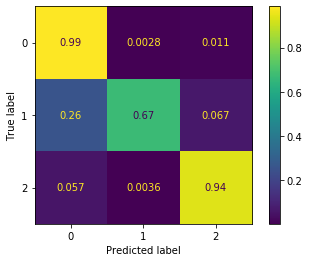

In [68]:
utils.print_metrics(gs_rf.best_estimator_, X_train, y_train, "Training")

********** *** **********
********** Metrics for: Test **********
accuracy: 0.8073155800428528
********** Classification Report **********
              precision    recall  f1-score   support

           0       0.90      0.80      0.85     12012
           1       0.29      0.62      0.39       667
           2       0.77      0.84      0.81      6923

    accuracy                           0.81     19602
   macro avg       0.65      0.75      0.68     19602
weighted avg       0.83      0.81      0.82     19602

********** Confusion Matrix **********


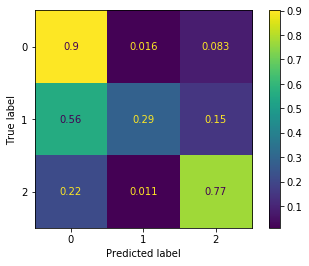

In [69]:
utils.print_metrics(gs_rf.best_estimator_, X_test, y_test, "Test")

### Training RandomForest model

In [78]:
# rf_params = ParameterGrid(gs_rf.param_grid)[1] # select best params
rf_params = gs_rf.best_params_
rf_params

{'clf__bootstrap': True,
 'clf__class_weight': None,
 'clf__max_features': 'auto',
 'clf__min_samples_leaf': 2,
 'clf__min_samples_split': 2,
 'clf__n_estimators': 300}

In [79]:
rf = get_pipeline_model(RandomForestClassifier()).set_params(**rf_params,)
rf = rf.fit(X_train, y_train)

********** *** **********
********** Metrics for: Training **********
accuracy: 0.9468566259611035
********** Classification Report **********
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     22924
           1       0.68      0.95      0.79      2065
           2       0.94      0.97      0.96     14809

    accuracy                           0.95     39798
   macro avg       0.87      0.95      0.90     39798
weighted avg       0.95      0.95      0.95     39798

********** Confusion Matrix **********


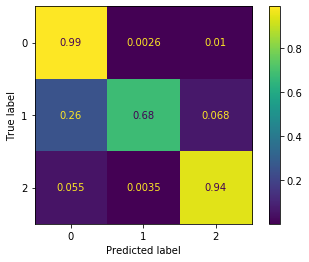

In [80]:
utils.print_metrics(rf, X_train, y_train, "Training")

********** *** **********
********** Metrics for: Test **********
accuracy: 0.8068054280175492
********** Classification Report **********
              precision    recall  f1-score   support

           0       0.90      0.80      0.85     12051
           1       0.29      0.63      0.40       665
           2       0.77      0.84      0.80      6886

    accuracy                           0.81     19602
   macro avg       0.65      0.76      0.68     19602
weighted avg       0.83      0.81      0.82     19602

********** Confusion Matrix **********


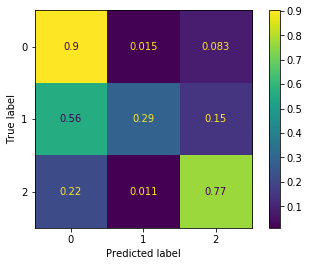

In [86]:
utils.print_metrics(rf, X_test, y_test, "Test")

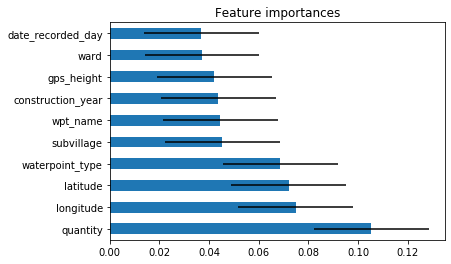

In [152]:
utils.plot_feature_importances(rf.steps[-1][1], FINAL_COLUMNS)

### Train Final Model

In [88]:
rf_final = get_pipeline_model(RandomForestClassifier()).set_params(**rf_params,)
rf_final = rf_final.fit(X,y)

********** *** **********
********** Metrics for:  **********
accuracy: 0.9458585858585858
********** Classification Report **********
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     34255
           1       0.67      0.95      0.79      3071
           2       0.94      0.97      0.96     22074

    accuracy                           0.95     59400
   macro avg       0.87      0.95      0.90     59400
weighted avg       0.95      0.95      0.95     59400

********** Confusion Matrix **********


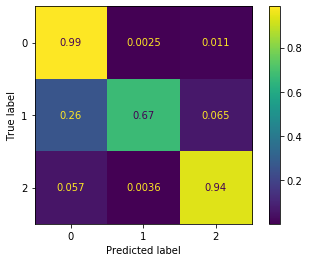

In [89]:
utils.print_metrics(rf_final, X, y)

### Submission Predictions

In [157]:
predictions = rf_final.predict(datatest)
predictions = y_transformer.inverse_transform(predictions)
now_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
pd.DataFrame(predictions, index=datatest.index, columns=['status_group']).to_csv(f'../data/results/results-rf-{now_str}.csv')

In [139]:
def get_predictions(clf, name, to_predict):
    predictions = clf.predict(to_predict)
    predictions = y_transformer.inverse_transform(predictions)
    now_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    pd.DataFrame(predictions, index=datatest.index, columns=['status_group']).to_csv(f'../data/results/results-{name}-{now_str}.csv')

____________________________________
### Other models!
____________________________________

### LightGBM


In [92]:
# other scikit-learn modules
estimator = LGBMClassifier(
    silent=False,
)

param_grid = {
    'learning_rate': [0.1],
    'n_estimators': [300],
    'subsample': [0.7],
    'num_leaves': [40],
    #'max_depth': [15],
    'colsample_bytree': [0.7],
    'reg_alpha': [
        #.5, 
         1, 
        #1.2
        #1e-2
    ],
    'reg_lambda': [
       .5,
      #  1e-2, 
      #  1e-1
    ],
    'objective': [
        #'multiclass', 
        'multiclassova'
    ]
    # 'min_child_weight':[0.001, 0.01, 0.05], 
}

param_fit_grid={
    'eval_set': [(X_test_preprocess, y_test)],
    'verbose':False,
    'early_stopping_rounds':10
}

gbm = GridSearchCV(
    estimator, 
    param_grid, 
    scoring= {
         'f1_score': make_scorer(f1_score, average='micro'),
         'accuracy': make_scorer(accuracy_score)
    }, 
    cv=StratifiedKFold(3), 
    return_train_score=True, 
    verbose=True,
    refit='accuracy'#'f1_score'
)

gbm = gbm.fit(
    X_train_preprocess, 
    y_train, 
    **param_fit_grid, 
    categorical_feature=list(TEXT_COLUMNS),   
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.6s finished


In [94]:
# test other parameters
gbm.best_params_, gbm.best_score_

({'colsample_bytree': 0.7,
  'learning_rate': 0.1,
  'n_estimators': 300,
  'num_leaves': 40,
  'objective': 'multiclassova',
  'reg_alpha': 1,
  'reg_lambda': 0.5,
  'subsample': 0.7},
 0.790341223177044)

In [95]:
pd.DataFrame(gbm.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_n_estimators,param_num_leaves,param_objective,param_reg_alpha,param_reg_lambda,param_subsample,params,split0_test_f1_score,split1_test_f1_score,split2_test_f1_score,mean_test_f1_score,std_test_f1_score,rank_test_f1_score,split0_train_f1_score,split1_train_f1_score,split2_train_f1_score,mean_train_f1_score,std_train_f1_score,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,mean_train_accuracy,std_train_accuracy
0,3.570603,0.194909,0.42803,0.012692,0.7,0.1,300,40,multiclassova,1,0.5,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",0.798583,0.791045,0.781396,0.790341,0.007034,1,0.84807,0.847053,0.847505,0.847543,0.000416,0.798583,0.791045,0.781396,0.790341,0.007034,1,0.84807,0.847053,0.847505,0.847543,0.000416


********** *** **********
********** Metrics for:  **********
accuracy: 0.7961942658912355
********** Classification Report **********
              precision    recall  f1-score   support

           0       0.89      0.79      0.84     11991
           1       0.31      0.62      0.41       716
           2       0.76      0.83      0.79      6895

    accuracy                           0.80     19602
   macro avg       0.65      0.74      0.68     19602
weighted avg       0.82      0.80      0.80     19602

********** Confusion Matrix **********


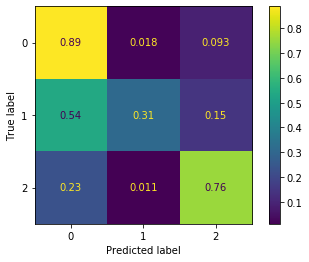

In [93]:
utils.print_metrics(gbm.best_estimator_, X_test_preprocess, y_test)

### Train LGB model

In [99]:
model_lgb = LGBMClassifier(
    **gbm.best_params_,
    silent=False,
    #class_weight= compute_weights(y_train)
#     scale_pos_weight=1
)

model_lgb.fit(
    X_train_preprocess, y_train, 
    eval_set= [(X_train_preprocess, y_train), (X_test_preprocess, y_test)],
    verbose=False,
    early_stopping_rounds=10,
    categorical_feature=list(TEXT_COLUMNS),
)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=-1, num_leaves=40,
               objective='multiclassova', random_state=None, reg_alpha=1,
               reg_lambda=0.5, silent=False, subsample=0.7,
               subsample_for_bin=200000, subsample_freq=0)

********** *** **********
********** Metrics for:  **********
accuracy: 0.8499422081511634
********** Classification Report **********
              precision    recall  f1-score   support

           0       0.93      0.83      0.88     24191
           1       0.41      0.78      0.54      1536
           2       0.81      0.88      0.85     14071

    accuracy                           0.85     39798
   macro avg       0.72      0.83      0.76     39798
weighted avg       0.87      0.85      0.86     39798

********** Confusion Matrix **********


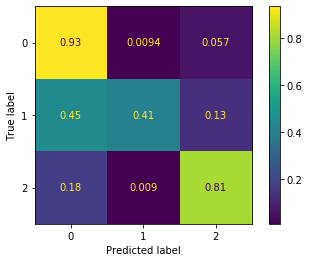

In [102]:
utils.print_metrics(model_lgb, X_train_preprocess, y_train)

********** *** **********
********** Metrics for:  **********
accuracy: 0.7961942658912355
********** Classification Report **********
              precision    recall  f1-score   support

           0       0.89      0.79      0.84     11991
           1       0.31      0.62      0.41       716
           2       0.76      0.83      0.79      6895

    accuracy                           0.80     19602
   macro avg       0.65      0.74      0.68     19602
weighted avg       0.82      0.80      0.80     19602

********** Confusion Matrix **********


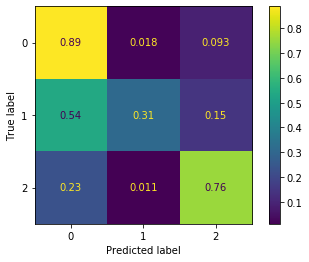

In [103]:
utils.print_metrics(model_lgb, X_test_preprocess, y_test)

### Test LGB model

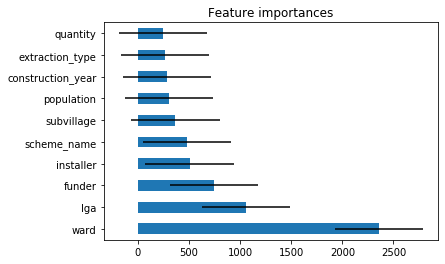

In [105]:
utils.plot_feature_importances(model_lgb, FINAL_COLUMNS)

### LGB for final prediction

In [107]:
final_lgb =  LGBMClassifier(
   **gbm.best_params_,
    silent=True
)

final_lgb.fit(
    X_prepro, y
)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=-1, num_leaves=40,
               objective='multiclassova', random_state=None, reg_alpha=1,
               reg_lambda=0.5, silent=True, subsample=0.7,
               subsample_for_bin=200000, subsample_freq=0)

In [108]:
accuracy_score(final_lgb.predict(X_prepro, num_iteration=final_lgb.best_iteration_), y)

0.8565319865319865

In [109]:
predictions = final_lgb.predict(datatest_prepro)
predictions = y_transformer.inverse_transform(predictions)

In [110]:
# export data for submition
now_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
pd.DataFrame(predictions, index=datatest.index, columns=['status_group']).to_csv(f'../data/results/results-lgb-{now_str}.csv')

TODO: Next part need refactors
_____________________________

### XGBClassifier
same approach but for xgb

In [ ]:
params_xgb = {
    "eta": [0.1],
    "max_depth": [7],
    "gamma": [0.8],
    "min_child_weight": [1],
    "subsample": [0.5],
    "colsample_bytree": [0.8],
    "max_bin": [256],
    "n_estimators":[500]
}

params_fit_xgb = {
    'early_stopping_rounds':5, 
    'eval_metric':"auc",
    'eval_set':[(X_test_preprocess, y_test)]
}

xgb_model = XGBClassifier()
gs_xgb = GridSearchCV(
    xgb_model,params_xgb, 
    verbose=1, 
    scoring= {'accuracy': make_scorer(accuracy_score)}, 
    cv=StratifiedKFold(3), 
    return_train_score=True, 
    refit='accuracy', 
    n_jobs=3
)

gs_xgb.fit(X_train_preprocess, y_train, **param_fit_grid)

In [ ]:
gs_xgb.best_params_, gs_xgb.best_score_,

In [ ]:
pd.DataFrame(gs_xgb.cv_results_)

In [ ]:
xgb_model = XGBClassifier(
    **gs_xgb.best_params_,
    silent=False,
)


xgb_model.fit(
    X_train_preprocess, y_train, 
    eval_set= [(X_train_preprocess, y_train), (X_test_preprocess, y_test)],
    verbose=False,
    early_stopping_rounds=10,
)

print(accuracy_score(xgb_model.predict(X_train_preprocess), y_train))
print(accuracy_score(xgb_model.predict(X_test_preprocess), y_test))

In [ ]:
print(classification_report(y_train, xgb_model.predict(X_train_preprocess)))
print(classification_report(y_test, xgb_model.predict(X_test_preprocess)))

In [ ]:
plot_importance_xgb(xgb_model, max_num_features=10)

### XGB for final prediction (deployment)

In [ ]:
final_xgb = XGBClassifier(
  **gs_xgb.best_params_,
    silent=True
).fit(X_prepro, y)
accuracy_score(final_xgb.predict(X_prepro), y)

In [ ]:
predictions = final_xgb.predict(datatest_prepro)
predictions = y_transformer.inverse_transform(predictions)
pd.DataFrame(predictions, index=datatest.index, columns=['status_group']).to_csv('../data/results/results-3-xgb.csv')

__________________________
## StackingClassifier 

In [144]:
clf1=RandomForestClassifier(
    **{'bootstrap': True,
 'class_weight': None,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}
, verbose=True)

clf2=LGBMClassifier(**gbm.best_params_, silent=False)
lr = XGBClassifier(verbose=True)

sclf = StackingClassifier(
    classifiers=[clf1, clf2], 
    meta_classifier=lr,
    use_probas=True,
    average_probas=False,
    verbose=1
)

sclf.fit(X_train_preprocess, y_train)

print(accuracy_score(sclf.predict(X_train_preprocess), y_train))
print(accuracy_score(sclf.predict(X_test_preprocess), y_test))

Fitting 2 classifiers...
Fitting classifier1: randomforestclassifier (1/2)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   23.4s finished


Fitting classifier2: lgbmclassifier (2/2)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.6s finished


0.9849238655208804


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.3s finished


0.7748188960310173


In [145]:
print(classification_report(y_train, sclf.predict(X_train_preprocess)))
print(classification_report(y_test, sclf.predict(X_test_preprocess)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.6s finished


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     21614
           1       0.94      0.96      0.95      2892
           2       0.99      0.99      0.99     15292

    accuracy                           0.98     39798
   macro avg       0.97      0.98      0.98     39798
weighted avg       0.98      0.98      0.98     39798



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.3s finished


              precision    recall  f1-score   support

           0       0.82      0.81      0.81     10645
           1       0.49      0.40      0.44      1425
           2       0.76      0.80      0.78      7532

    accuracy                           0.77     19602
   macro avg       0.69      0.67      0.68     19602
weighted avg       0.77      0.77      0.77     19602



____________________
## Ensemble Voting

In [141]:
eclf = EnsembleVoteClassifier(
    clfs=[rf_final.steps[-1][1], final_lgb], 
    weights=[1.5,1], 
    refit=False,
    voting='soft'
)

eclf = eclf.fit(X_prepro, y)

********** *** **********
********** Metrics for:  **********
accuracy: 0.8191245791245791
********** Classification Report **********
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     39068
           1       0.18      0.92      0.29       825
           2       0.76      0.89      0.82     19507

    accuracy                           0.82     59400
   macro avg       0.63      0.86      0.66     59400
weighted avg       0.88      0.82      0.84     59400

********** Confusion Matrix **********


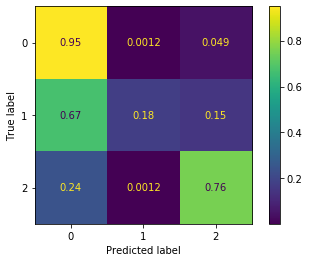

In [142]:
utils.print_metrics(eclf, X_prepro, y)

In [140]:
get_predictions(eclf, 'eclf', datatest_prepro)

_______________________
## CatBoost

In [ ]:
cat_final = CatBoostClassifier(
    silent=False,
    use_best_model=True,
    eval_metric='Accuracy',
    n_estimators=1000,
    learning_rate=0.1
    
).fit(X_prepro, y,
    early_stopping_rounds= 5,
)
accuracy_score(cat_final.predict(X_prepro), y)


In [ ]:
predictions = cat_final.predict(datatest_prepro)
predictions = y_transformer.inverse_transform(predictions)
now_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
pd.DataFrame(predictions, index=datatest.index, columns=['status_group']).to_csv(f'../data/results/results-cat-{now_str}.csv')

In [ ]:

utils.plot_feature_importances(model_lgb, X_prepro.columns)


## Other models

In [ ]:
from sklearn.linear_model import LogisticRegression, 
    SGDClassifier
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
lr_final = OneVsRestClassifier(LogisticRegression()).fit(X_prepro, y)
accuracy_score(lr_final.predict(X_prepro), y)

In [ ]:
lr_final = OneVsRestClassifier(SGDClassifier()).fit(X_prepro, y)
accuracy_score(lr_final.predict(X_prepro), y)

In [ ]:
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers


In [ ]:
y_train_onehot = OneHotEncoder().fit_transform(y_train.reshape(-1,1)).toarray()
y_test_onehot = OneHotEncoder().fit_transform(y_test.reshape(-1,1)).toarray()

In [ ]:
model_keras = tf.keras.Sequential([
    layers.Dense(5000, input_shape=(32,)),
    layers.Dropout(0.3),
    layers.Dense(100, activation='tanh'),
    layers.Dense(y_train_onehot.shape[1], activation='softmax')
])

model_keras.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_keras.fit(
    X_train_preprocess, y_train_onehot,
    validation_data=(X_test_preprocess,y_test_onehot),
    epochs=5
)